# 3.1 Logistic Regression

Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px

import random
np.random.seed(123)
random.seed(123)

# machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from tempfile import mkdtemp
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score,recall_score,precision_score,f1_score, roc_auc_score


# Filter warnings
import warnings
warnings.filterwarnings('ignore')

# Print all columns of a datafame
pd.set_option('display.max_columns', None)

# Table of Contents
* [Introduction](#introduction)
* [Data Loading](#data-loading)
* [Baseline Model](#baseline-model)
* [Scaled Model](#scaled-model)
* [Model Optimization](#model-optimization)
    * [Hyperparameter Tuning](#hyperparameter-tuning)
* [Top Features](#top-features)

---

## Introduction <a id="introduction"></a>

**Streamlining Renewable Energy Site Selection with ML:
Predict the Suitability of Solar Energy Resources**

The goal of this project is to apply machine learning techniques to classify whether solar is suitable as the primary energy source for a location.

This can help energy decision makers and energy companies to simplify the complex site selection process, thereby accelerating the transition to clean and sustainable energy sources, ultimately contributing to the fight against climate change and energy crisis. 

This notebook will perform Logistic Regression on the renewable power plants data with geospatial data. We will also perform model optimization by tuning the hyperparameters to find the best model with the highest recall and accuracy score.


---

## Data Loading <a id="data-loading"></a>

In [2]:
df = pd.read_csv("./data/capstone_data_cleaned_for_model.csv")

df_shape = df.shape
cat_cols = len(df.select_dtypes('object').columns)
num_cols = len(df.select_dtypes('number').columns)

print(f'Rows: {df_shape[0]}')
print(f'Columns: {df_shape[1]}\n')

print(f'Total duplicate rows: {df.duplicated().sum()}')
print(f'Percentage duplicate rows: {df.duplicated().mean()}% \n')

print(f'Total null values: {df.isna().sum().sum()}')
print(f'Percentage null vales: {df.isna().mean().sum()}% \n')

df.info()

print("\n")

print(f'Number of categorical columns: {cat_cols}')
print(f'Number of numerical columns: {num_cols}')

Rows: 7784
Columns: 6

Total duplicate rows: 0
Percentage duplicate rows: 0.0% 

Total null values: 0
Percentage null vales: 0.0% 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7784 entries, 0 to 7783
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Longitude       7784 non-null   float64
 1   WindSpeed       7784 non-null   float64
 2   SolarRadiation  7784 non-null   float64
 3   Elevation       7784 non-null   float64
 4   Slope           7784 non-null   float64
 5   isSolar         7784 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 365.0 KB


Number of categorical columns: 0
Number of numerical columns: 6


---

## Baseline Model <a id="baseline-model"></a>

Set up the model

In [3]:
X = df.drop(columns=['isSolar'])
y = df['isSolar']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

print(f'Shape of test set: {X_test.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of test set: (1557, 5)
Shape of train set: (6227, 5)


In [5]:
# Instantiate the model
base_logreg = LogisticRegression(max_iter=10000, random_state=1)

# Fit the model
base_logreg.fit(X_train, y_train)

# Scoring the model
base_logreg.score(X_train, y_train)
base_logreg.score(X_test, y_test)

print(f'Baseline logreg Train result: {base_logreg.score(X_train, y_train):.4f} accuracy.')
print(f'Baseline logreg Test result: {base_logreg.score(X_test, y_test):.4f} accuracy.')

Baseline logreg Train result: 0.7299 accuracy.
Baseline logreg Test result: 0.7168 accuracy.


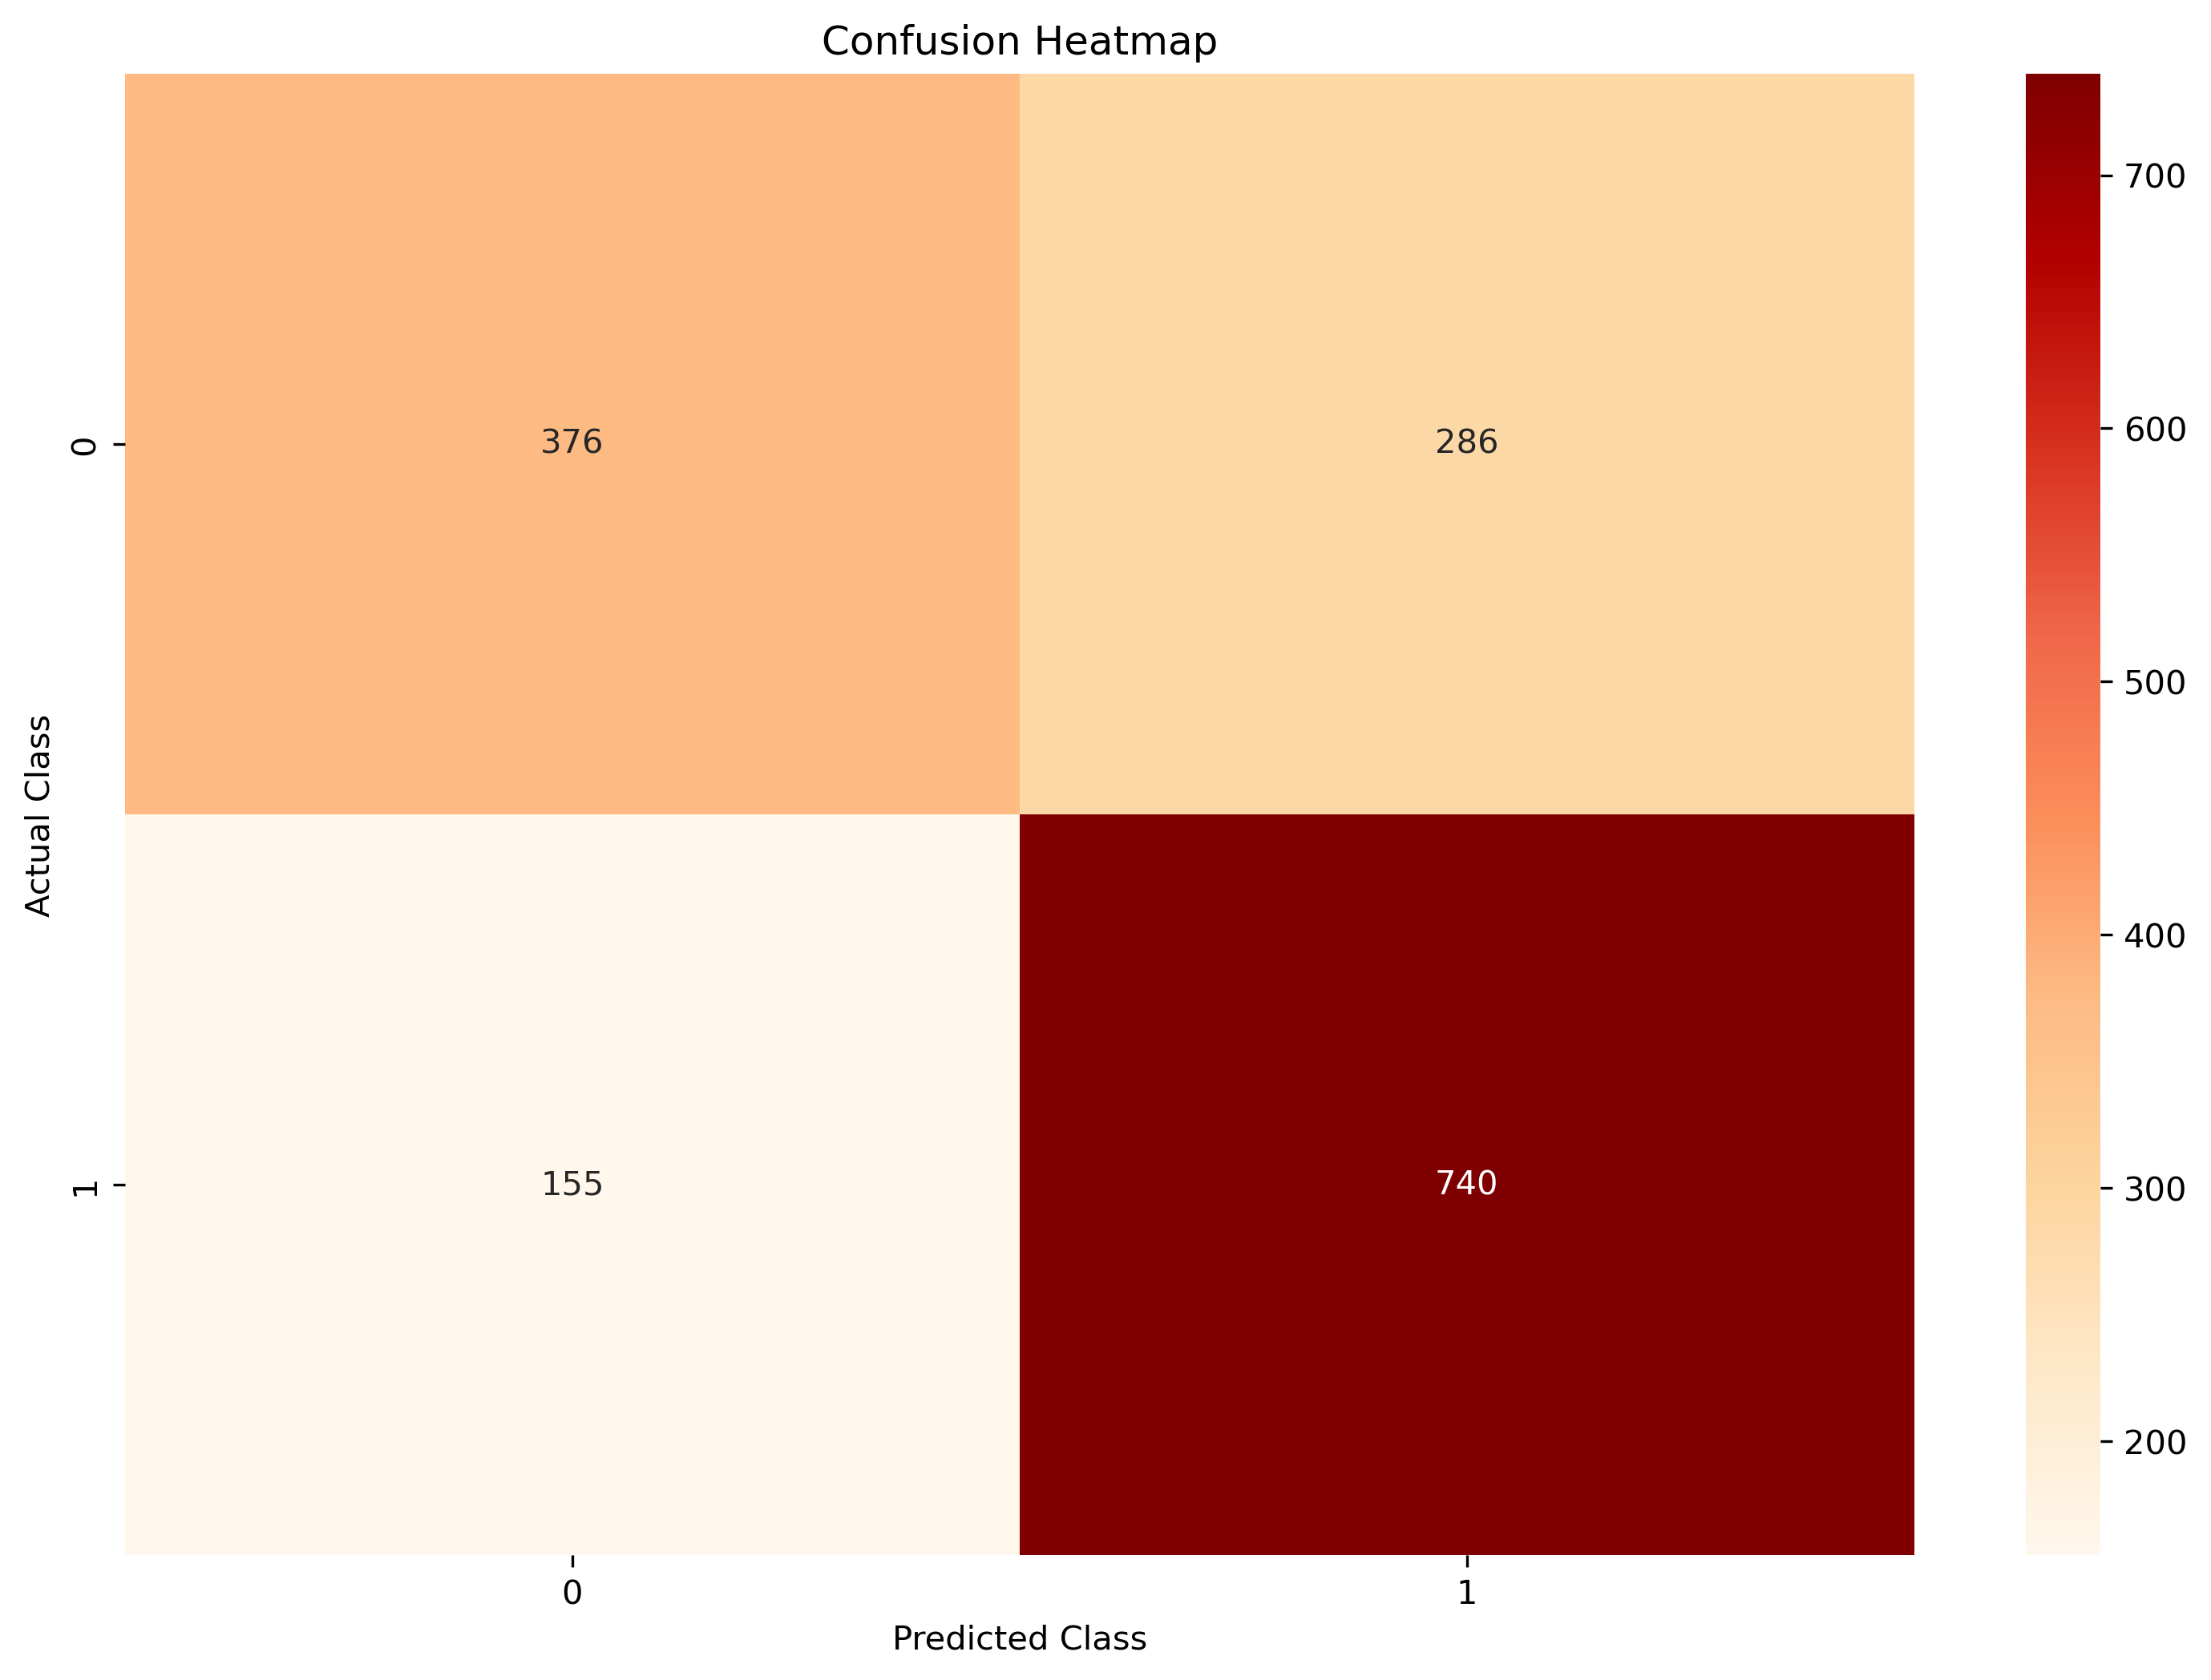

              precision    recall  f1-score   support

           0       0.71      0.57      0.63       662
           1       0.72      0.83      0.77       895

    accuracy                           0.72      1557
   macro avg       0.71      0.70      0.70      1557
weighted avg       0.72      0.72      0.71      1557



In [6]:
# Make classifications based on the test features, and assign the classifications to a variable
y_pred = base_logreg.predict(X_test)

predictions = y_test.unique()
predictions.sort()

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
confusion_df.index = [i for i in predictions]
confusion_df.columns = [i for i in predictions]

# Heatmap of the above
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='OrRd') # Passing in fmt='d' prevents the counts from being displayed in scientific notation
plt.title('Confusion Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

print(classification_report(y_test, y_pred))

In [7]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred)))

Accuracy Score : 0.7167630057803468
Precision Score : 0.7212475633528265
Recall Score : 0.8268156424581006
F1 Score : 0.7704320666319625
ROC AUC Score : 0.6973957366369052


In the following sections of the notebook, we will perform different techniques such as scaling in attempt to increase the recall score. Let's create a DataFrame to store all the scores for different version of the model.

In [8]:
# Create the score df
scores_df = {
    "ModelName": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1": [],
    "ROC AUC": []
}

def appendScores (model_name, y_test, y_pred):
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    roc_auc = roc_auc_score(y_test,y_pred)

    scores_df["ModelName"].append(model_name)
    scores_df["Accuracy"].append(accuracy)
    scores_df["Precision"].append(precision)
    scores_df["Recall"].append(recall)
    scores_df["F1"].append(f1)
    scores_df["ROC AUC"].append(roc_auc)

    return pd.DataFrame(scores_df)

In [9]:
# Append the scores of the baseline logistic regression model to the dataframe
appendScores("Baseline_Logreg", y_test, y_pred)

,ModelName,Accuracy,Precision,Recall,F1,ROC AUC
0,Baseline_Logreg,0.716763,0.721248,0.826816,0.770432,0.697396


---

## Scaled Model <a id="scaled-model"></a>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

print(f'Shape of test set: {X_test.shape}')
print(f'Shape of train set: {X_train.shape}')

# Instantiate the scaler
ss = StandardScaler()

# Fit to the train dataset only
ss.fit(X_train)

# Transform the train and test
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

# Instantiate Logistic regression
logit_scaled = LogisticRegression(max_iter=10000, random_state=1)

# Fit to the scaled train data
logit_scaled.fit(X_train_scaled, y_train)

# Scoring the model
logit_scaled.score(X_train_scaled, y_train)
logit_scaled.score(X_test_scaled, y_test)

print(f'Train result after scaling: {logit_scaled.score(X_train_scaled, y_train):.4f} accuracy.')
print(f'Test result after scaling: {logit_scaled.score(X_test_scaled, y_test):.4f} accuracy.')

Shape of test set: (1557, 5)
Shape of train set: (6227, 5)
Train result after scaling: 0.7294 accuracy.
Test result after scaling: 0.7161 accuracy.


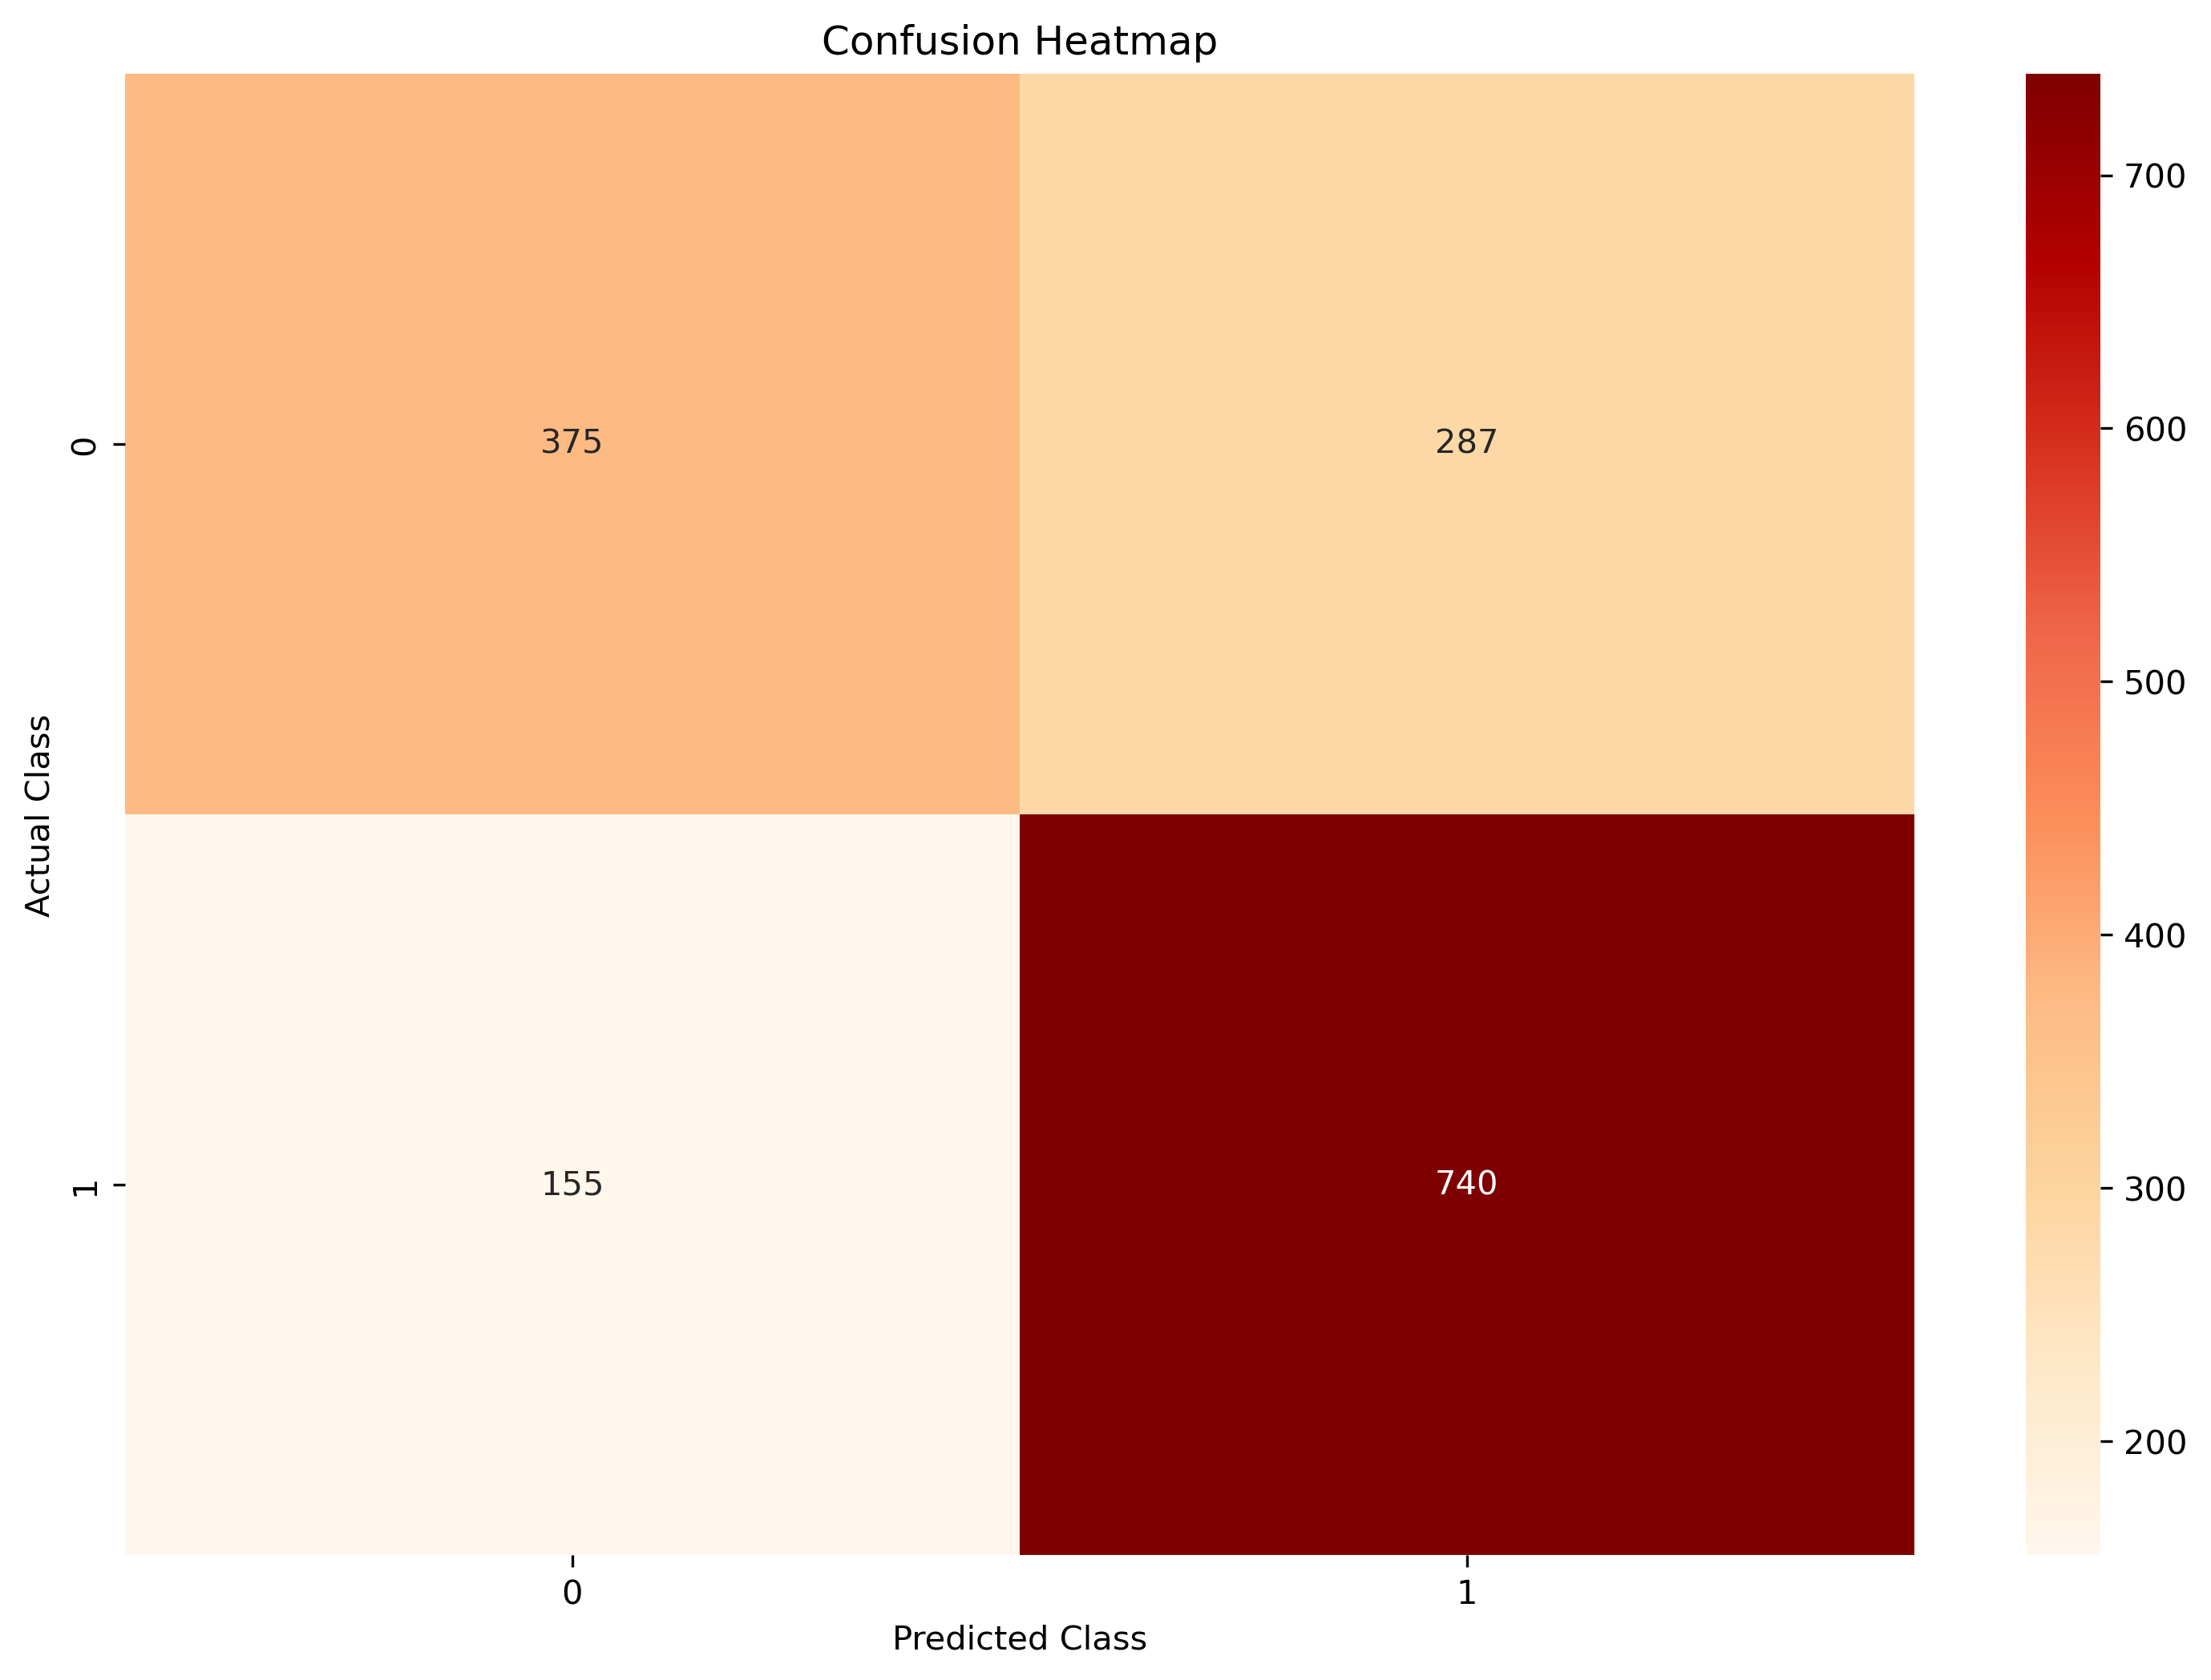

              precision    recall  f1-score   support

           0       0.71      0.57      0.63       662
           1       0.72      0.83      0.77       895

    accuracy                           0.72      1557
   macro avg       0.71      0.70      0.70      1557
weighted avg       0.72      0.72      0.71      1557



In [11]:
# Make classifications based on the test features, and assign the classifications to a variable
y_pred = logit_scaled.predict(X_test_scaled)

predictions = y_test.unique()
predictions.sort()

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
confusion_df.index = [i for i in predictions]
confusion_df.columns = [i for i in predictions]

# Heatmap of the above
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='OrRd') # Passing in fmt='d' prevents the counts from being displayed in scientific notation
plt.title('Confusion Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

print(classification_report(y_test, y_pred))

In [12]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred)))

Accuracy Score : 0.7161207450224791
Precision Score : 0.7205452775073028
Recall Score : 0.8268156424581006
F1 Score : 0.7700312174817899
ROC AUC Score : 0.6966404496278418


In [13]:
# Append the scores of the scaled logistic regression model to the dataframe
appendScores("StandardScaled_Logreg", y_test, y_pred)

,ModelName,Accuracy,Precision,Recall,F1,ROC AUC
0,Baseline_Logreg,0.716763,0.721248,0.826816,0.770432,0.697396
1,StandardScaled_Logreg,0.716121,0.720545,0.826816,0.770031,0.696640


We can see that scaling using the standard method doesn't improve the model. Let's try using `MinMaxScaler`.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

print(f'Shape of test set: {X_test.shape}')
print(f'Shape of train set: {X_train.shape}')

# Instantiate the scaler
ss = MinMaxScaler()

# Fit to the train dataset only
ss.fit(X_train)

# Transform the train and test
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

# Instantiate Logistic regression
logit_scaled = LogisticRegression(max_iter=10000, random_state=1)

# Fit to the scaled train data
logit_scaled.fit(X_train_scaled, y_train)

# Scoring the model
logit_scaled.score(X_train_scaled, y_train)
logit_scaled.score(X_test_scaled, y_test)

print(f'Train result after scaling: {logit_scaled.score(X_train_scaled, y_train):.4f} accuracy.')
print(f'Test result after scaling: {logit_scaled.score(X_test_scaled, y_test):.4f} accuracy.')

Shape of test set: (1557, 5)
Shape of train set: (6227, 5)
Train result after scaling: 0.7243 accuracy.
Test result after scaling: 0.7046 accuracy.


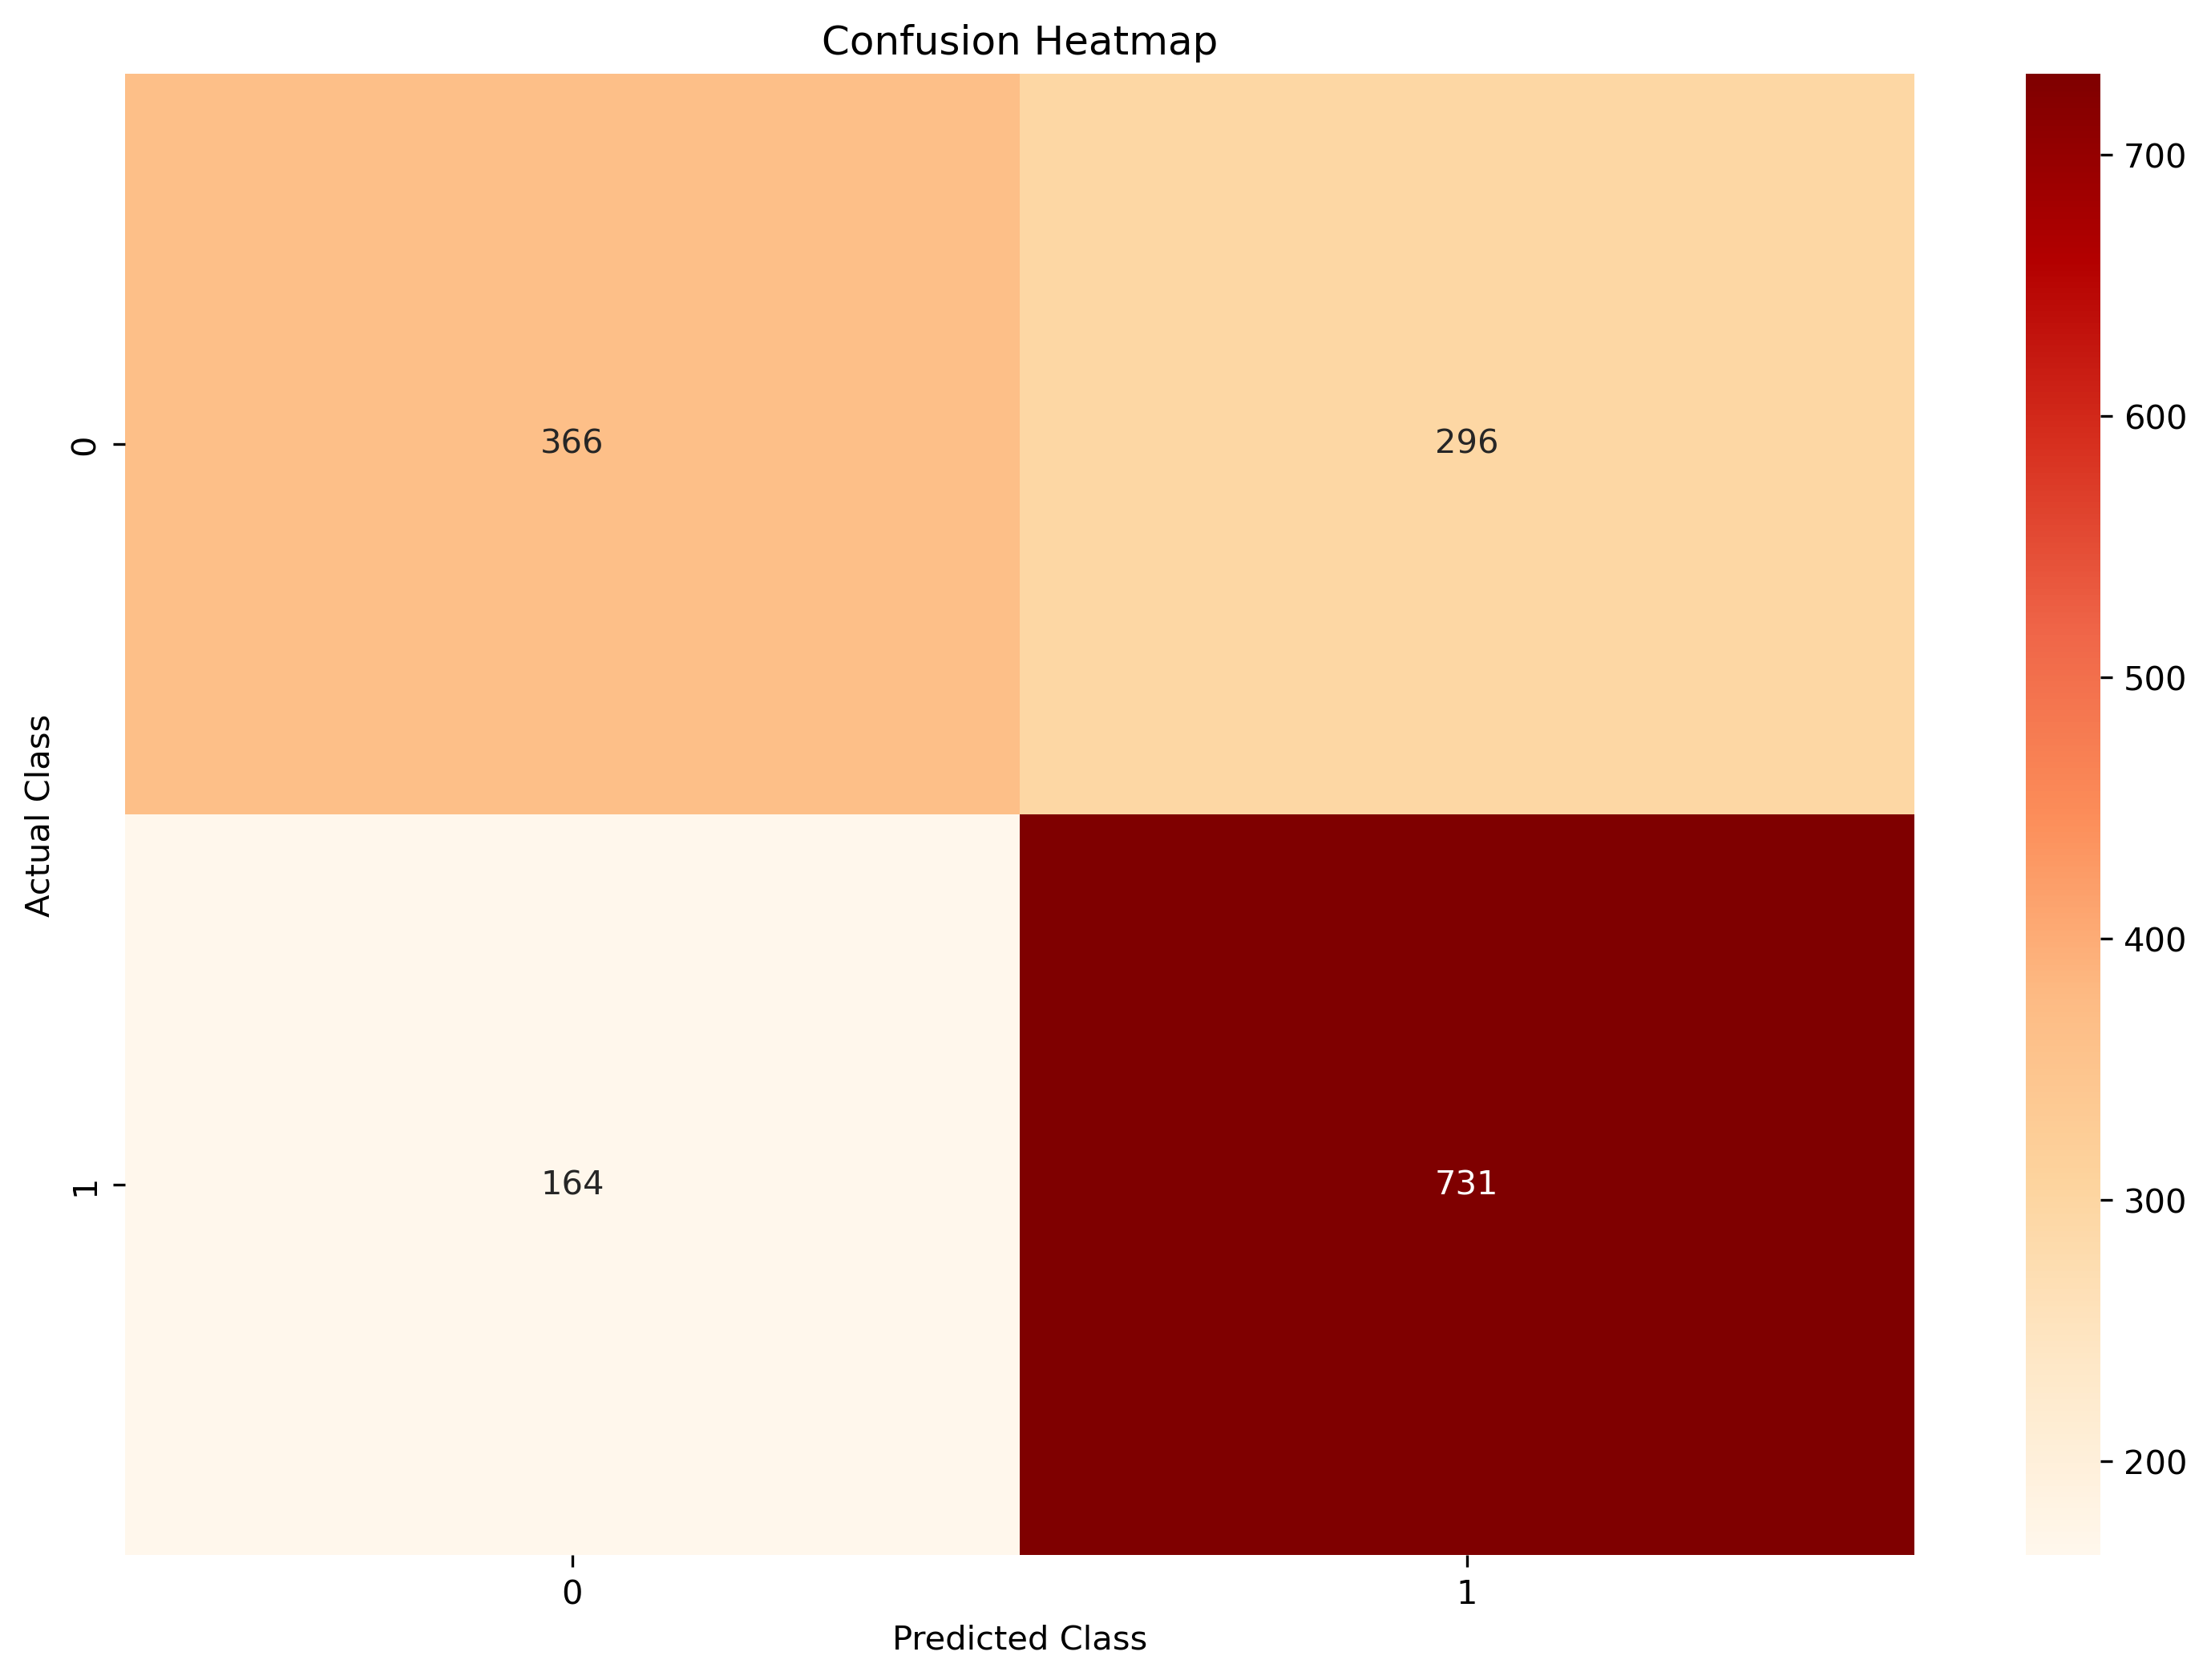

              precision    recall  f1-score   support

           0       0.69      0.55      0.61       662
           1       0.71      0.82      0.76       895

    accuracy                           0.70      1557
   macro avg       0.70      0.68      0.69      1557
weighted avg       0.70      0.70      0.70      1557



In [15]:
# Make classifications based on the test features, and assign the classifications to a variable
y_pred = logit_scaled.predict(X_test_scaled)

predictions = y_test.unique()
predictions.sort()

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
confusion_df.index = [i for i in predictions]
confusion_df.columns = [i for i in predictions]

# Heatmap of the above
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='OrRd') # Passing in fmt='d' prevents the counts from being displayed in scientific notation
plt.title('Confusion Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

print(classification_report(y_test, y_pred))

In [16]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred)))

Accuracy Score : 0.7045600513808606
Precision Score : 0.7117818889970788
Recall Score : 0.8167597765363128
F1 Score : 0.7606659729448492
ROC AUC Score : 0.6848149335853768


In [17]:
# Append the scores of the scaled logistic regression model to the dataframe
appendScores("MinMaxScaled_Logreg", y_test, y_pred)

,ModelName,Accuracy,Precision,Recall,F1,ROC AUC
0,Baseline_Logreg,0.716763,0.721248,0.826816,0.770432,0.697396
1,StandardScaled_Logreg,0.716121,0.720545,0.826816,0.770031,0.696640
2,MinMaxScaled_Logreg,0.704560,0.711782,0.816760,0.760666,0.684815


With MinMaxScaler, the model actually perform worse. This suggests scaling doesn't work well with our model, and we can ignore it for our future models.

As of dimension reduction with `PCA()`, there isn't a need for that as our model has a small dimension. We will skip that part here, but include that in our `GridSearch`.

---

## Model Optimization <a id="model-optimization"></a>

- Penalty: either L1 or L2;
- C: a c value ranging from 0.001 to 100 as we saw that the optimum score was achieved with a value of 1;
- Solver: this will be either lbfgs or liblinear.

In [18]:
# Split the data into remainder and test sets
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Print info on how the data has been split
print(f'The remainder set has {len(X_rem)} data points.')
print(f'The test set has {len(X_test)} data points.')

# Split the remainder set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.2, random_state=1, stratify=y_rem)

# Print info on how the data has been split
print(f'The train set has {len(X_train)} data points.')
print(f'The validation set has {len(X_val)} data points.')

The remainder set has 6227 data points.
The test set has 1557 data points.
The train set has 4981 data points.
The validation set has 1246 data points.


### Hyperparameter Tuning: 5-folds Cross Validation with GridSearch <a id="hyperparameter-tuning"></a>

In [19]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

estimators = [('scaler', StandardScaler()),
              ('dim_reducer', PCA()),
              ('model', LogisticRegression())

]

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline(estimators, memory=cachedir)

# Let's try the same range of C values from earlier
c_values = [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000]

# Parameter grid
logreg_param_grid = [
    
    # l1 without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(penalty='l1', solver='liblinear', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l1 with PCA
    {'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(penalty='l1', solver='liblinear', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l2 (default) without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(penalty='l2', solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l2 (default) with PCA
    {'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(penalty='l2', solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values}
]

In [20]:
from sklearn.metrics import balanced_accuracy_score
# Instantiate the log reg grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, scoring=make_scorer(balanced_accuracy_score), cv=5, n_jobs=-1, verbose=1)

# Fit the log reg grid search
fitted_logreg_gs = logreg_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


/Users/tyu/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/tyu/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/tyu/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/tyu/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set

In [21]:
fitted_logreg_gs.best_estimator_

Pipeline(memory='/var/folders/s_/7zs1_mq56sn__p5wmr52p3hr0000gn/T/tmpe912sxjp',
         steps=[('scaler', None), ('dim_reducer', None),
                ('model',
                 LogisticRegression(C=0.01, n_jobs=-1, random_state=1))])

In [22]:
# Print the accuracies
print(f"The best logistic regression's accuracy on the remainder set: {fitted_logreg_gs.score(X_rem, y_rem)}")
print(f"The best logistic regression's accuracy on the test set: {fitted_logreg_gs.score(X_test, y_test)}")

The best logistic regression's accuracy on the remainder set: 0.7121986660183734
The best logistic regression's accuracy on the test set: 0.6995054768856859


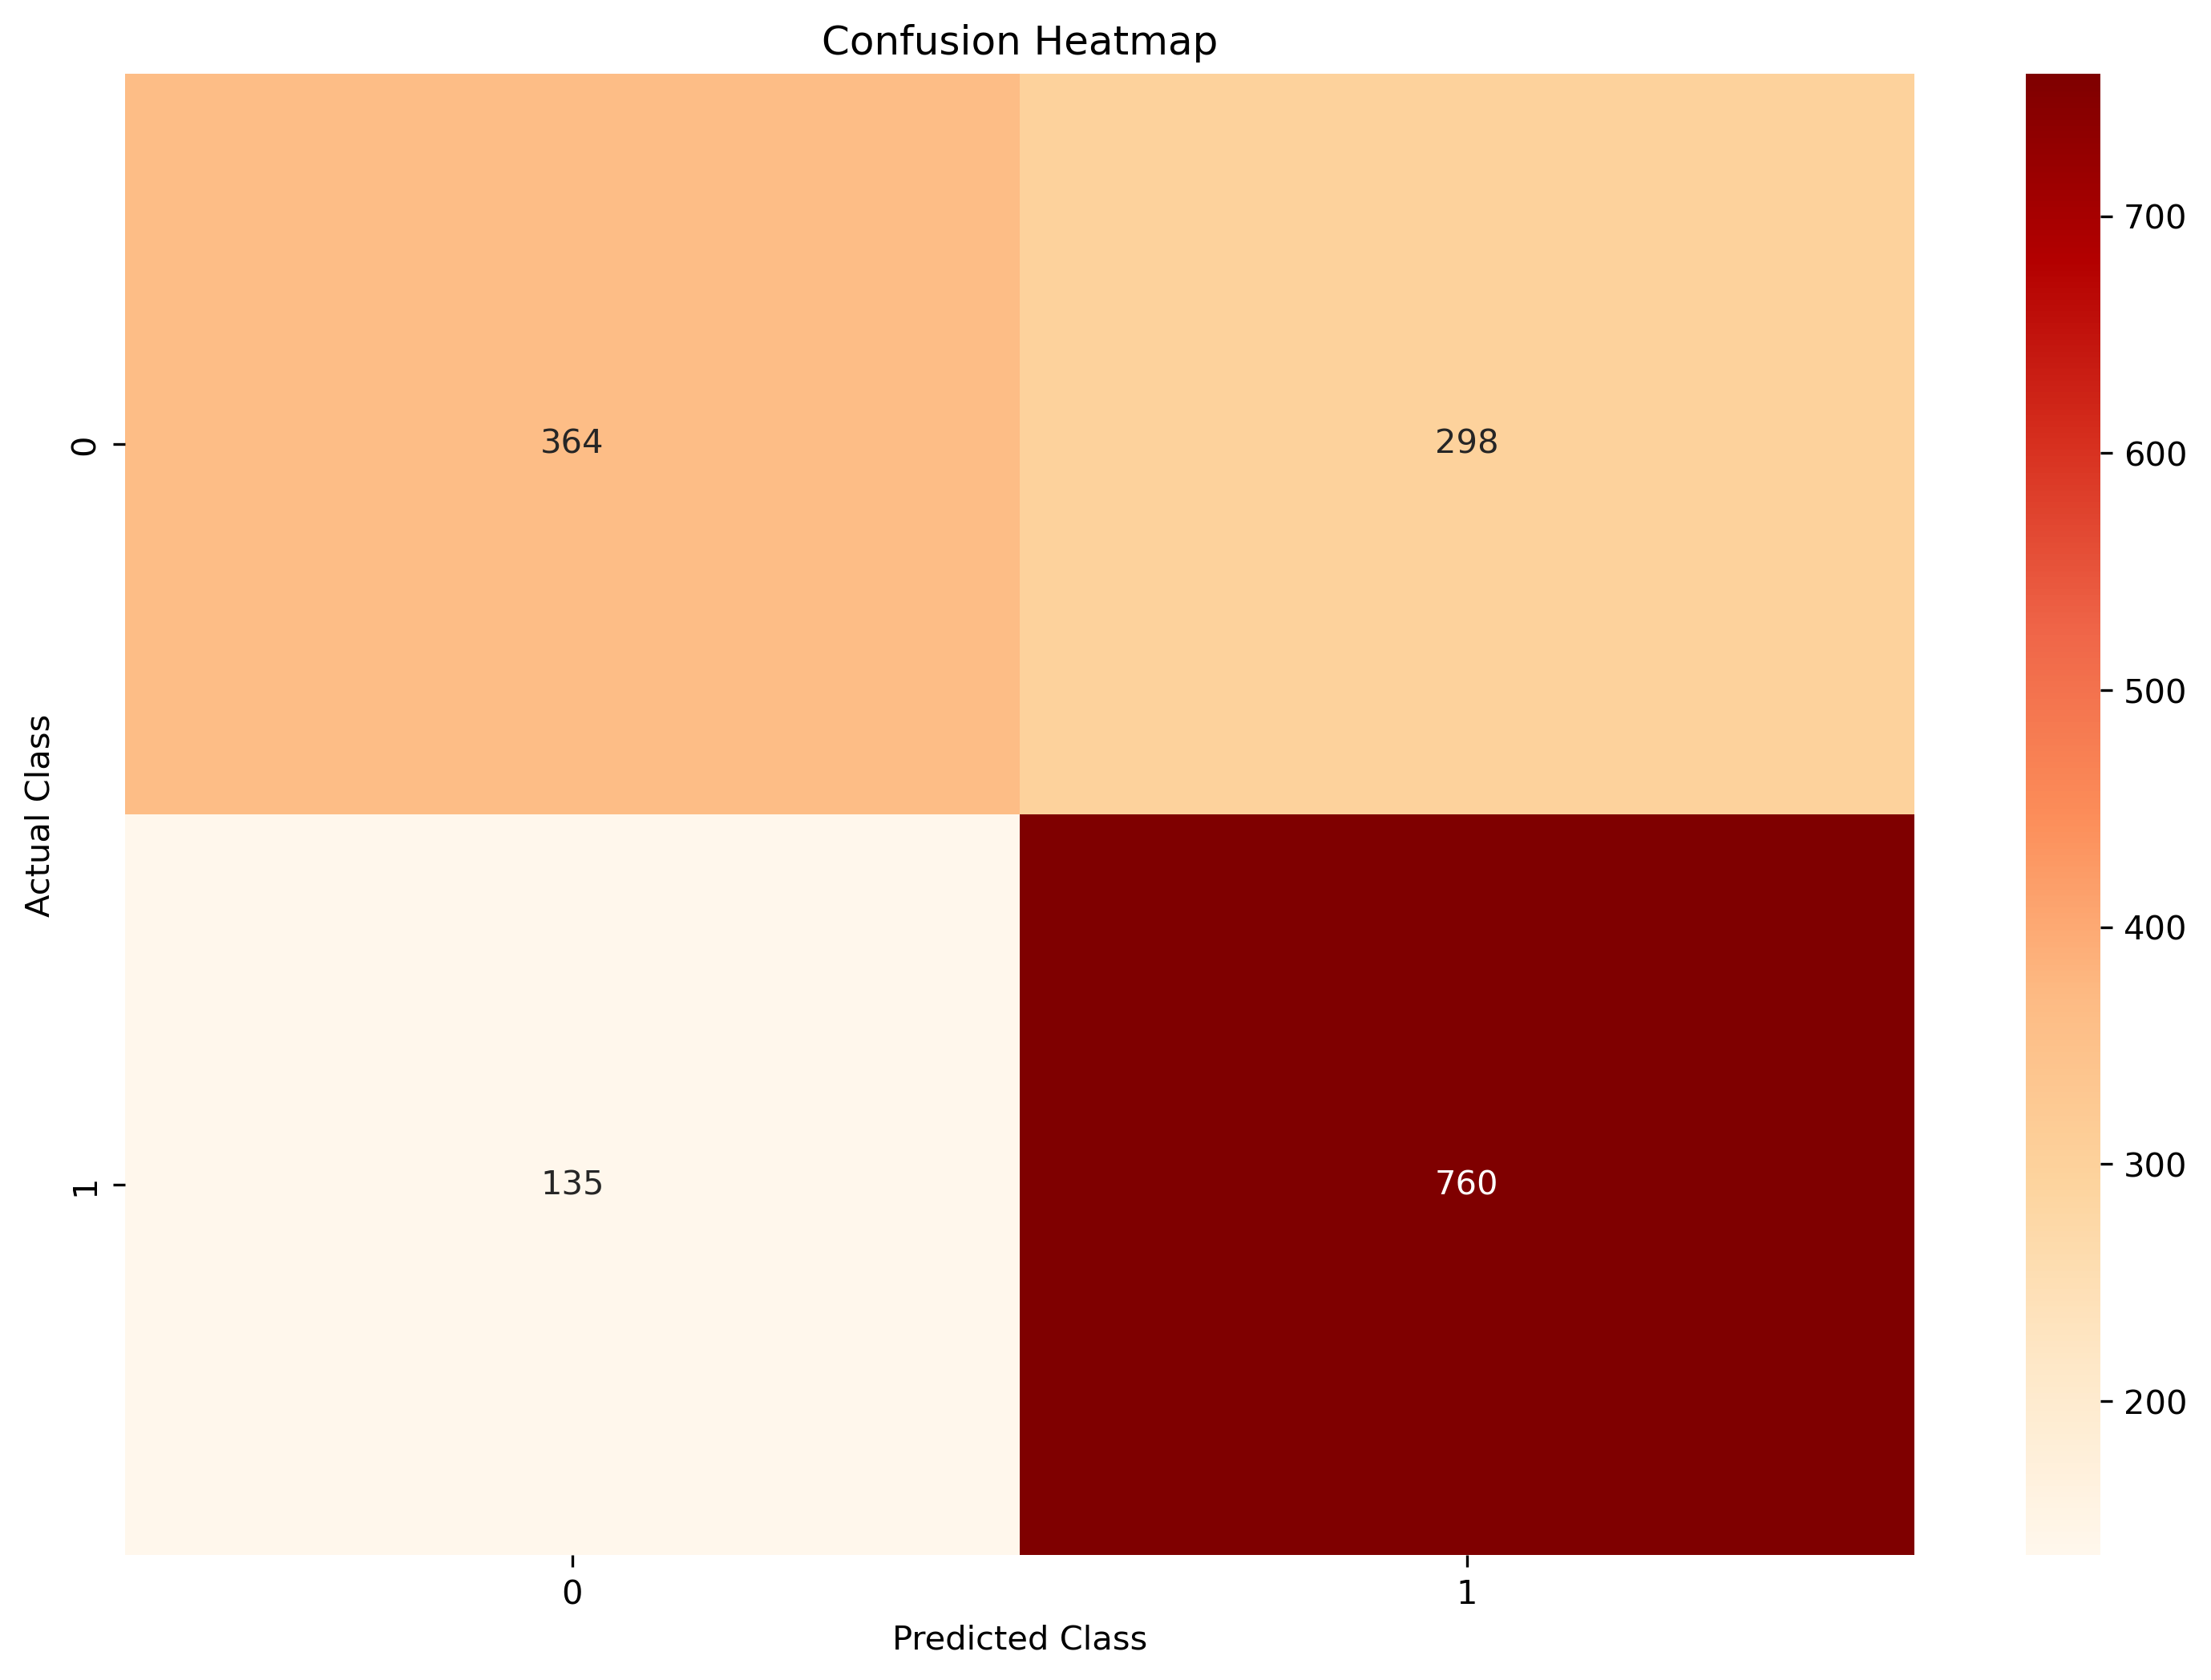

              precision    recall  f1-score   support

           0       0.73      0.55      0.63       662
           1       0.72      0.85      0.78       895

    accuracy                           0.72      1557
   macro avg       0.72      0.70      0.70      1557
weighted avg       0.72      0.72      0.71      1557



In [23]:
# Make classifications based on the test features, and assign the classifications to a variable
y_pred = fitted_logreg_gs.predict(X_test)

predictions = y_test.unique()
predictions.sort()

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
confusion_df.index = [i for i in predictions]
confusion_df.columns = [i for i in predictions]

# Heatmap of the above
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='OrRd') # Passing in fmt='d' prevents the counts from being displayed in scientific notation
plt.title('Confusion Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

print(classification_report(y_test, y_pred))

In [24]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred)))

Accuracy Score : 0.7219010918432883
Precision Score : 0.718336483931947
Recall Score : 0.8491620111731844
F1 Score : 0.778289810547875
ROC AUC Score : 0.6995054768856859


In [25]:
# Append the scores of the scaled logistic regression model to the dataframe
appendScores("GridSearch_Logreg", y_test, y_pred)

,ModelName,Accuracy,Precision,Recall,F1,ROC AUC
0,Baseline_Logreg,0.716763,0.721248,0.826816,0.770432,0.697396
1,StandardScaled_Logreg,0.716121,0.720545,0.826816,0.770031,0.696640
2,MinMaxScaled_Logreg,0.704560,0.711782,0.816760,0.760666,0.684815
3,GridSearch_Logreg,0.721901,0.718336,0.849162,0.778290,0.699505


Using GridSearch, it helps us to find the best model with higher recall and accuracy compared to the baseline model.

The best Logistic Regression Model's Hyperparameters:
- Scaler: None
- Dimension Reduction: None
- C: 0.01

## Top Features <a id="top-features"></a>

In [26]:
best_model = fitted_logreg_gs.best_estimator_.get_params()["model"]

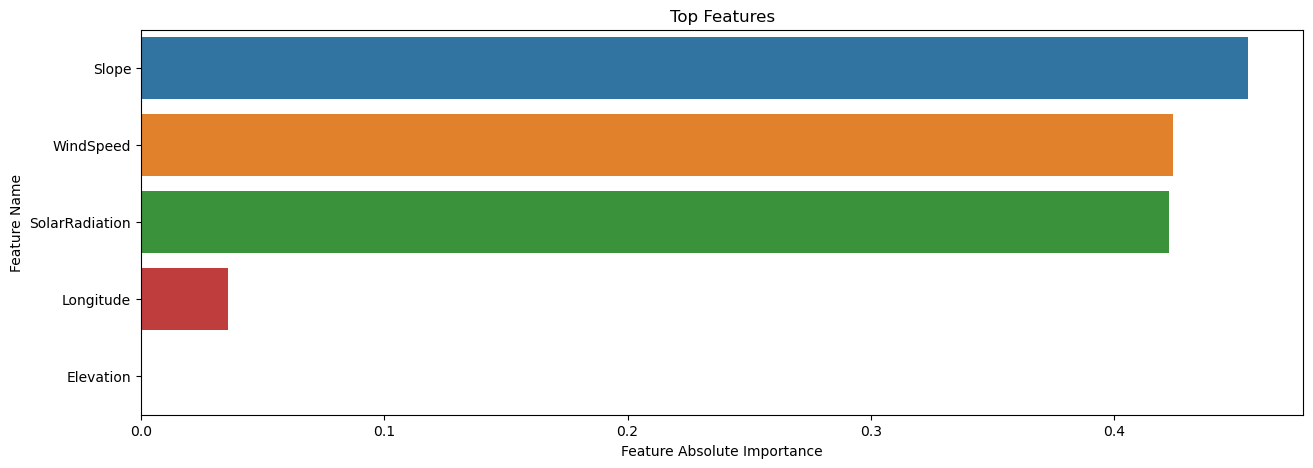

In [27]:
# plot the absolute of the coefficients
importances = np.abs(best_model.coef_[0])
importances_df = pd.DataFrame({'Variable': X.columns,
                                'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(15, 5))
plt.title('Top Features')
sns.barplot(x='Importance', y='Variable', data=importances_df.head(10))
plt.xlabel('Feature Absolute Importance')
plt.ylabel('Feature Name')
plt.show()

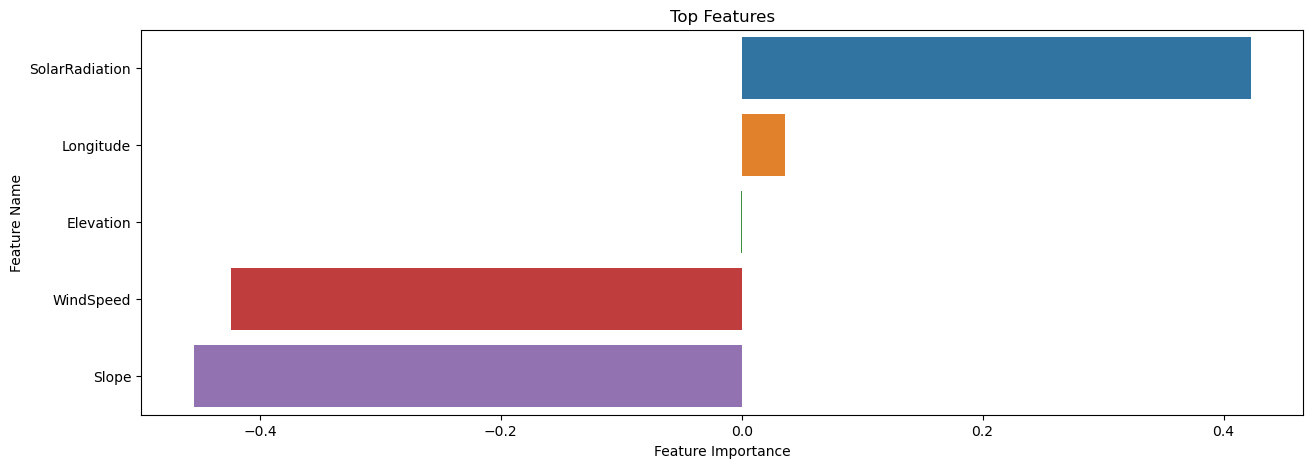

In [28]:
# plot the absolute of the coefficients
importances = best_model.coef_[0]
importances_df = pd.DataFrame({'Variable': X.columns,
                                'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(15, 5))
plt.title('Top Features')
sns.barplot(x='Importance', y='Variable', data=importances_df.head(10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

Assuming the relationship between the predictor variables and the target variable is linear, `Slope` is the most important predictor to whether solar energy is suitable or not. The lower the magnitude of slope, the higher the odds for a location to be suitable for solar energy.

This suggests the odds for a location to be suitable for solar energy would have lower slope and higher solar radiation.

---

## Saving the best model

In [29]:
import pickle

pickle.dump(best_model, open('./models/logreg_model.pkl', 'wb'))

Loading the model

In [30]:
import pickle
fittedgrid = pickle.load(open('models/logreg_model.pkl', 'rb'))